#### [ 지도학습 - 회귀 ]
- 회귀(Regression) : 수치값을 예측하는 학습
    * 예 : 거리, 시간, 무게, 집가격 등등 ...

- 주제 : 생선 길이에 따른 무게를 예측하는 모델
- 방법 : 최근접이웃 알고리즘

[1] 모듈 로딩 및 데이터 준비 <hr>

In [74]:
## ==========================================
## [1-1] 모듈 로딩
## ==========================================
import pandas as pd
import numpy as np

## 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib

## ML 관련
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

## Cow 활성화 : 복사와 공유 자동 설정 기능 활성화
pd.options.mode.copy_on_write = True

# 판다스/넘파이에 지수표기법(과학적표기법) 정지 설정
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(precision=6, suppress=True)



In [75]:
## =======================================
## [1-2] 데이터 준비 및 확인
## =======================================
## 데이터 준비
data_file = '../Data/fish_train_10500.csv'

## Bream, Smelt 생선 데이터 추출
fishDF = pd.read_csv(data_file)

(fishDF.Species == 'Bream') | (fishDF.Species == 'Smelt')

dataDF = fishDF[fishDF.Species.isin(['Bream', 'Smelt'])]
dataDF = dataDF[['Weight', 'Length','Species']]
dataDF

,Weight,Length,Species
0,487.42334,32.42375,Bream
1,990.89654,41.36527,Bream
2,627.08172,33.44470,Bream
3,749.38272,35.68641,Bream
4,615.62195,33.52775,Bream
...,...,...,...
10495,7.84624,11.21824,Smelt
10496,14.77972,13.10661,Smelt
10497,13.13453,12.38393,Smelt
10498,8.09812,10.94337,Smelt


        Weight  Length
Weight 1.00000 0.96938
Length 0.96938 1.00000


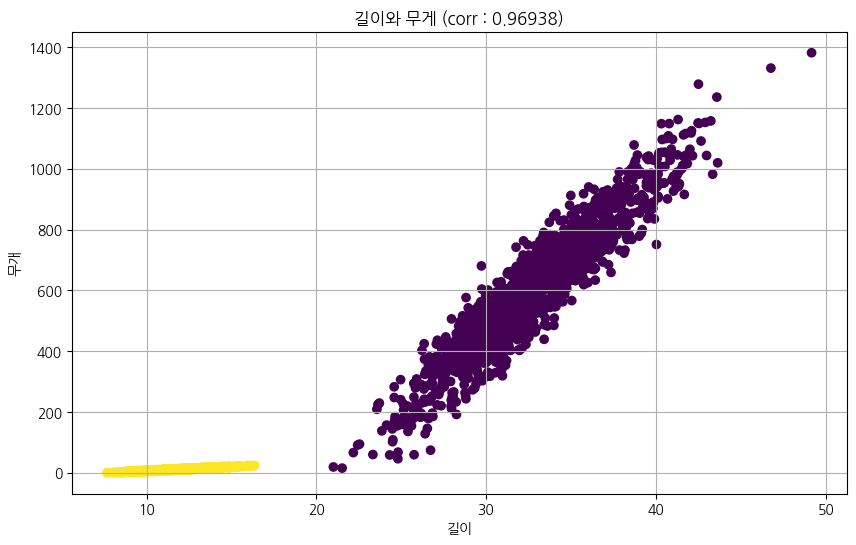

In [76]:
## 길이와 무게, 품종 관계 시각화
dataDF['Species'] = dataDF['Species'].astype('category')
corr_ = dataDF.corr(numeric_only=True)
print(corr_)

plt.figure(figsize=(10,6))
plt.scatter(dataDF.Length, dataDF.Weight, c = dataDF.Species.cat.codes)
plt.title(f"길이와 무게 (corr : {corr_['Weight']['Length']:.5f})")
plt.xlabel('길이')
plt.ylabel('무개')
plt.grid()
plt.show()

[2] 피쳐와 타겟/학습용과 테스트 분리 <hr>

In [77]:
featureDF = dataDF[dataDF.columns[1:-1]] ## 길이
# print(featureDF.shape)
targetSR = dataDF[dataDF.columns[0]]     ## 무개
# print(targetSR.shape)

x_train, x_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    # stratify=targetSR ## 분류에만 사용, 회귀는 X
                                                    )

print(f'[TRAIN] x_train:{x_train.shape},  y_train:{y_train.shape}')
print(f'[TEST] x_test:{x_test.shape},  y_test:{y_test.shape}')

[TRAIN] x_train:(2400, 1),  y_train:(2400,)
[TEST] x_test:(600, 1),  y_test:(600,)


[3] 학습 진행 <hr>

In [78]:
## 모델 인스턴스 생성
kModel = KNeighborsRegressor()


In [79]:
## 학습진행 => 학습용 데이터셋만 사용
kModel.fit(x_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [80]:
## 학습 후 학습용데이터셋 기반 모델 파라미터 설정
## - 모델 파라미터 : 파라미터이름_
print('n_features_in_   :', kModel.n_features_in_)
print('n_feature_names_in   :', kModel.feature_names_in_)
print('n_samples_fit_   :', kModel.n_samples_fit_)

n_features_in_   : 1
n_feature_names_in   : ['Length']
n_samples_fit_   : 2400


[4] 성능평가 <hr>

In [81]:
## 훈련용 성능평가 & 테스트용 성능평가 비교
train_score = kModel.score(x_train, y_train)
test_score  = kModel.score(x_test, y_test)

print(f'train_score : {train_score}')
print(f'test_score  : {test_score}')

train_score : 0.9840456962283772
test_score  : 0.9734059843239307


[5] 예측 : 새로운 데이터 사용 <hr>
- predict(2D_새로운 피쳐) ==> 예측 무게 값
- n_neighbors의 무게를 추출 => 평균한 값과 예측무게 값이 같은지 체크

In [106]:
newDF = pd.DataFrame([[20],[3],[45],[60],[99]], columns=dataDF.columns[1:-1])
newDF

pre_weights = kModel.predict(newDF)
print(pre_weights.tolist())


[66.05078086828237, 0.5852548627420436, 1157.8127103661084, 1157.8127103661081, 1157.8127103661081]


In [107]:
dis_, indices = kModel.kneighbors(newDF)

neighbor_means = []

for i in range(len(indices)):         # i: newDF의 각 샘플(20, 3, 45)
    neigh_idx = indices[i]            # i번째 샘플의 이웃 인덱스들
    neigh_weights = y_train.iloc[neigh_idx].values  # 이웃들의 실제 무게
    mean_weight = np.mean(neigh_weights)            # 평균(=uniform일 때 예측값)
    neighbor_means.append(mean_weight)

    print(f"\n[newDF {i}] 길이={newDF.iloc[i,0]}")
    print("  이웃 인덱스:", neigh_idx.tolist())
    print("  이웃 무게:", np.round(neigh_weights, 3).tolist())
    print("  이웃 평균:", float(mean_weight))
    print("  모델 예측:", float(pre_weights[i]))

print("\n이웃 평균 리스트:", neighbor_means)
# 예측값과 이웃 평균이 같은지(또는 거의 같은지) 확인
print("\n예측값 == 이웃평균 ?", np.allclose(pre_weights, neighbor_means))


[newDF 0] 길이=20
  이웃 인덱스: [543, 1543, 306, 2058, 67]
  이웃 무게: [18.925, 66.246, 91.152, 94.051, 59.88]
  이웃 평균: 66.05078086828237
  모델 예측: 66.05078086828237

[newDF 1] 길이=3
  이웃 인덱스: [2251, 1078, 450, 376, 1703]
  이웃 무게: [0.075, 0.023, 0.807, 1.055, 0.966]
  이웃 평균: 0.5852548627420436
  모델 예측: 0.5852548627420436

[newDF 2] 길이=45
  이웃 인덱스: [973, 717, 1564, 789, 2298]
  이웃 무게: [1019.843, 1236.074, 1157.69, 1331.509, 1043.947]
  이웃 평균: 1157.8127103661084
  모델 예측: 1157.8127103661084

[newDF 3] 길이=60
  이웃 인덱스: [789, 973, 717, 1564, 2298]
  이웃 무게: [1331.509, 1019.843, 1236.074, 1157.69, 1043.947]
  이웃 평균: 1157.8127103661081
  모델 예측: 1157.8127103661081

[newDF 4] 길이=99
  이웃 인덱스: [789, 973, 717, 1564, 2298]
  이웃 무게: [1331.509, 1019.843, 1236.074, 1157.69, 1043.947]
  이웃 평균: 1157.8127103661081
  모델 예측: 1157.8127103661081

이웃 평균 리스트: [np.float64(66.05078086828237), np.float64(0.5852548627420436), np.float64(1157.8127103661084), np.float64(1157.8127103661081), np.float64(1157.8127103661081)]

예측값 

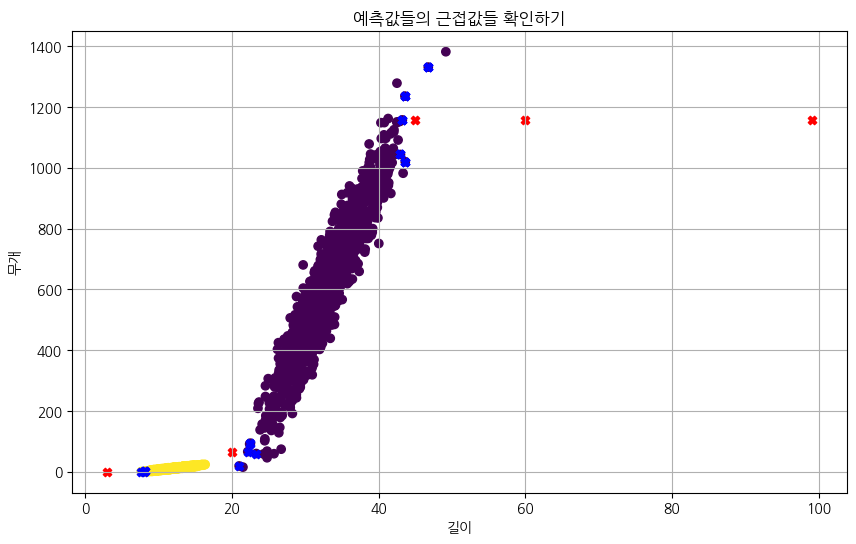

In [108]:
plt.figure(figsize=(10,6))

## 기존 데이터 셋
plt.scatter(dataDF.Length, dataDF.Weight, c = dataDF.Species.cat.codes)

## 새로운 데이터
for x in range(len(newDF)) :
    ## 예측값 찍기
    plt.scatter(newDF.iloc[x],pre_weights[x], c='red', marker='X')
    ## 예측값의 근접값
    for y in indices[x] :
        plt.scatter(x_train.iloc[y].Length, y_train.iloc[y], c="blue", marker= 'X')

plt.title(f"예측값들의 근접값들 확인하기")
plt.xlabel('길이')
plt.ylabel('무개')
plt.grid()
plt.show()